# Section 2.1 Feature Selection

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd


# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns; sns.set()


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def feature_selection_rf(X, y, n_estimators=100, random_state=42):
    """
    Perform feature selection using Random Forest based on OOB feature importance.
    
    Parameters:
    - X (DataFrame): Feature dataset
    - y (Series): Output variable
    - n_estimators (int): Number of trees in the forest (default=100)
    - random_state (int): Random state for reproducibility (default=42)
    
    Returns:
    - removed_features (list): List of removed features in the order they were dropped
    - rmse_list (list): RMSE values for each iteration
    - r2_list (list): R2 values for each iteration
    """

    X_loop = X.copy()  # avoid modifying the original data
    
    # Initialize lists to store results
    rmse_list = []
    r2_list = []
    important_features = []
    
    # Set up the Random Forest model with OOB enabled
    model = RandomForestRegressor(n_estimators=n_estimators, 
                                  oob_score=True, 
                                  random_state=random_state)
    
    # Loop until there are no features left
    while X_loop.shape[1] > 0:
        # Fit the model on the current dataset
        model.fit(X_loop, y)
        
        # Calculate OOB RMSE and R2
        oob_rmse = np.sqrt(mean_squared_error(y, model.oob_prediction_))
        oob_r2 = r2_score(y, model.oob_prediction_)
        
        # Record the performance metrics
        rmse_list.append(oob_rmse)
        r2_list.append(oob_r2)
        
        # Determine feature importances and identify the least important feature
        feature_importances = model.feature_importances_
        least_important_feature = X_loop.columns[np.argmin(feature_importances)]
        important_features.append(least_important_feature)
    
        
        # Drop the least important feature
        X_loop = X_loop.drop(columns=[least_important_feature])
    
    print("Feature Selection Complete")
    
    
    # Return the results as a dictionary
    return {
        "important_features": important_features,
        "rmse_list": rmse_list,
        "r2_list": r2_list
    }

In [3]:
def plot_rmse_r2_by_feature_importance(important_features, rmse_list, r2_list, file_prefix):
    """
    Plot RMSE and R2 scores by the remaining important features.

    Parameters:
    - important_features (list): List of retained important features in order of selection
    - rmse_list (list): RMSE values for each iteration of feature selection
    - r2_list (list): R2 values for each iteration of feature selection
    - file_prefix (str): Prefix for the filename to save the plot
    """
    # Set a style for white background with black grid
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create a figure and primary y-axis
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot RMSE on the primary y-axis
    ax1.plot(important_features, rmse_list, marker='o', color='b', label='OOB RMSE')
    ax1.set_ylabel('OOB RMSE (dB)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_xticks(range(len(important_features)))
    ax1.set_xticklabels(important_features, rotation=90)
    ax1.grid(visible=True, which='both', axis='both', color='gray', 
             linestyle='--', linewidth=0.5, alpha=0.5)  # Set grid style

    # Create a secondary y-axis for R2
    ax2 = ax1.twinx()
    ax2.plot(important_features, r2_list, marker='o', color='r', label='OOB R2')
    ax2.set_ylabel('OOB R2', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.grid(visible=False)  # Disable grid for secondary axis for clarity

    fig.tight_layout()

    # Save the plot 
    plt.savefig(f'Figure/eps/feature_selection/{file_prefix}_rmse_r2_results.eps', format='eps')
    plt.show()

In [4]:
def plot_green_line(important_features, rmse_list, r2_list, file_prefix, point):
    """
    Plot RMSE and R2 scores by the remaining important features.

    Parameters:
    - important_features (list): List of retained important features in order of selection
    - rmse_list (list): RMSE values for each iteration of feature selection
    - r2_list (list): R2 values for each iteration of feature selection
    - file_prefix (str): Prefix for the filename to save the plot
    """
    # Set a style for white background with black grid
    plt.style.use('_mpl-gallery-nogrid')
    
    # Create a figure and primary y-axis
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot RMSE on the primary y-axis
    ax1.plot(important_features, rmse_list, marker='o', color='b', label='OOB RMSE', linewidth=2, markersize=8)
    ax1.set_ylabel('OOB RMSE (dB)', color='b', fontsize = 24)
    ax1.tick_params(axis='y', labelcolor='b', labelsize = 24)
    ax1.set_xticks(range(len(important_features)))
    ax1.set_xticklabels(important_features, rotation=90, fontsize = 24)
    ax1.grid(visible=True, which='both', axis='both', color='gray', 
             linestyle='--', linewidth=0.5, alpha=0.5)  # Set grid style

    # Add a vertical dotted green line 
    x_index = important_features.index(point) + 0.5 
    ax1.axvline(x=x_index, color='green', linestyle='--', linewidth=4, label='Threshold')

    # Create a secondary y-axis for R2
    ax2 = ax1.twinx()
    ax2.plot(important_features, r2_list, marker='o', color='r', label='OOB R2', linewidth=2, markersize=8 )
    ax2.set_ylabel('OOB R2', color='r', fontsize = 22)
    ax2.tick_params(axis='y', labelcolor='r', labelsize = 22)
    ax2.grid(visible=False)  # Disable grid for secondary axis for clarity
    
    
    plt.title(file_prefix.split('_')[0], fontsize=22)
    fig.tight_layout()

    # Save the plot 
    plt.savefig(f'Figure/eps/feature_selection/{file_prefix}_rmse_r2_results_greenline.eps', format='eps')
    plt.show()

In [5]:
# Load generic datasets
X_data = {
    "X_Generic": pd.read_csv("Data/Splitting/Generic/X_train.csv")
}
y_data_FSO = {
    "y_Generic_FSO": pd.read_csv("Data/Splitting/Generic/y_train_FSO.csv").squeeze()
}
y_data_RF = {
    "y_Generic_RF": pd.read_csv("Data/Splitting/Generic/y_train_RF.csv").squeeze()
}

# Load specific datasets in a loop
for i in [0, 3, 4, 5, 6, 7, 8]:
    X_data[f"X_Specific{i}"] = pd.read_csv(f"Data/Splitting/Specific/train_X_SC_{i}.csv")
    y_data_FSO[f"y_Specific{i}_FSO"] = pd.read_csv(f"Data/Splitting/Specific/train_y_FSO_SC_{i}.csv").squeeze()
    y_data_RF[f"y_Specific{i}_RF"] = pd.read_csv(f"Data/Splitting/Specific/train_y_RF_SC_{i}.csv").squeeze()

**(1) Feature Selection for Generic Model on FSO Attenuation**

In [6]:
FSO_Generic_results = feature_selection_rf(X_data["X_Generic"].drop(columns=["Freq"]), y_data_FSO["y_Generic_FSO"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


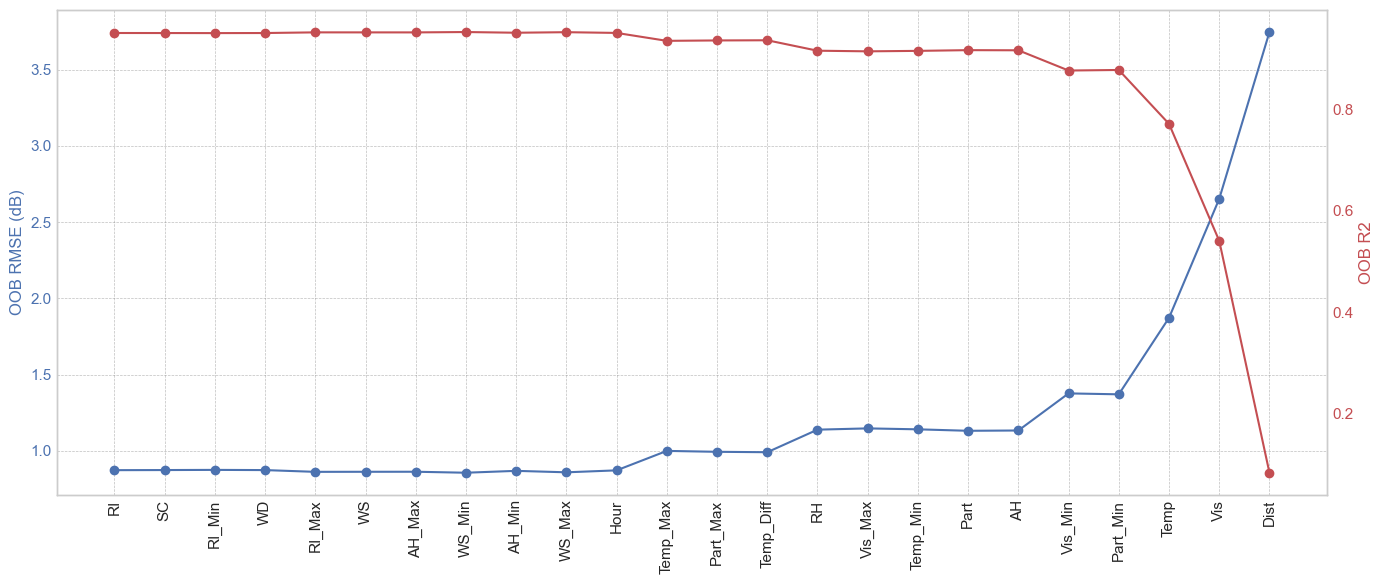

In [7]:
plot_rmse_r2_by_feature_importance(FSO_Generic_results["important_features"], 
                                   FSO_Generic_results["rmse_list"], 
                                   FSO_Generic_results["r2_list"],
                                   file_prefix="FSO_Generic")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


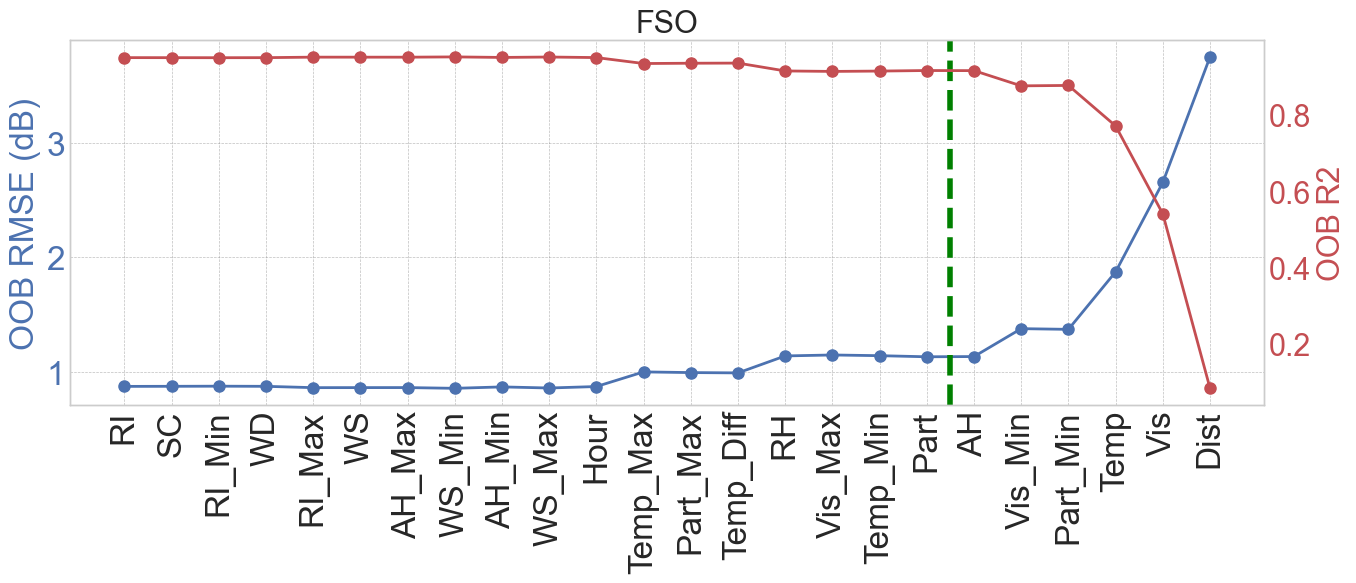

In [8]:
plot_green_line(FSO_Generic_results["important_features"], 
                FSO_Generic_results["rmse_list"], 
                FSO_Generic_results["r2_list"],
                file_prefix="FSO_Generic",
                point="Part")

**(2) Feature Selection for Specific Model on FSO Attenuation**

In [9]:
FSO_Specific0_results = feature_selection_rf(X_data["X_Specific0"].drop(columns=["Freq"]), y_data_FSO["y_Specific0_FSO"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


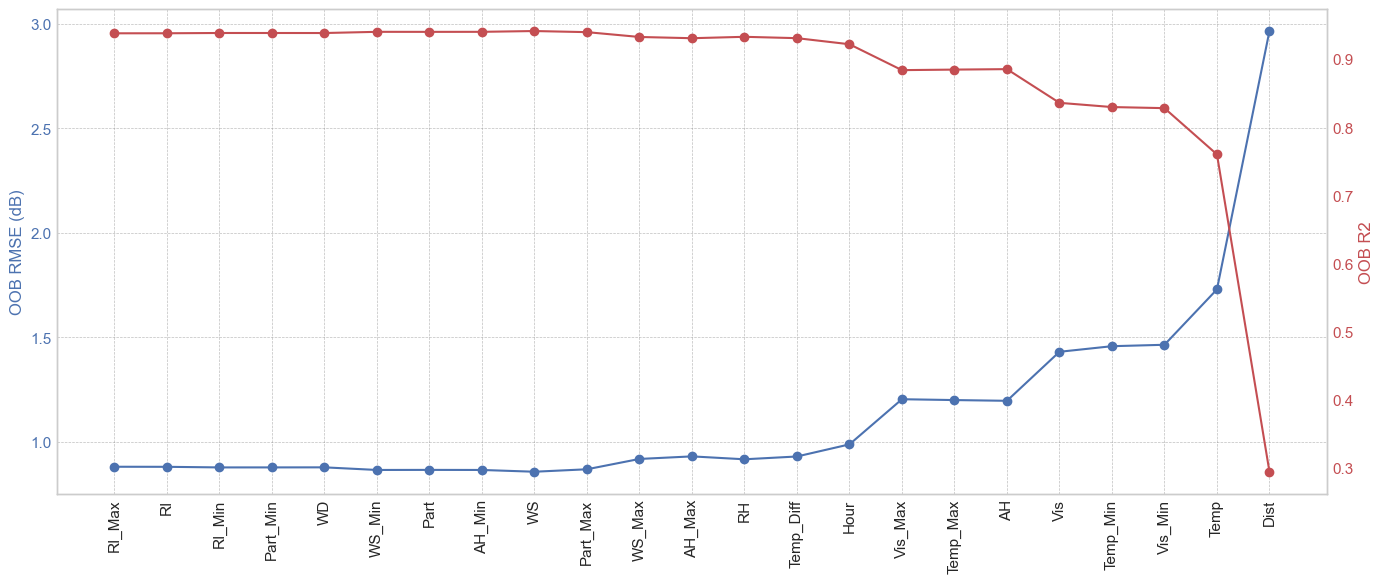

In [10]:
plot_rmse_r2_by_feature_importance(FSO_Specific0_results["important_features"], 
                                   FSO_Specific0_results["rmse_list"], 
                                   FSO_Specific0_results["r2_list"],
                                   file_prefix="FSO_Specific0")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


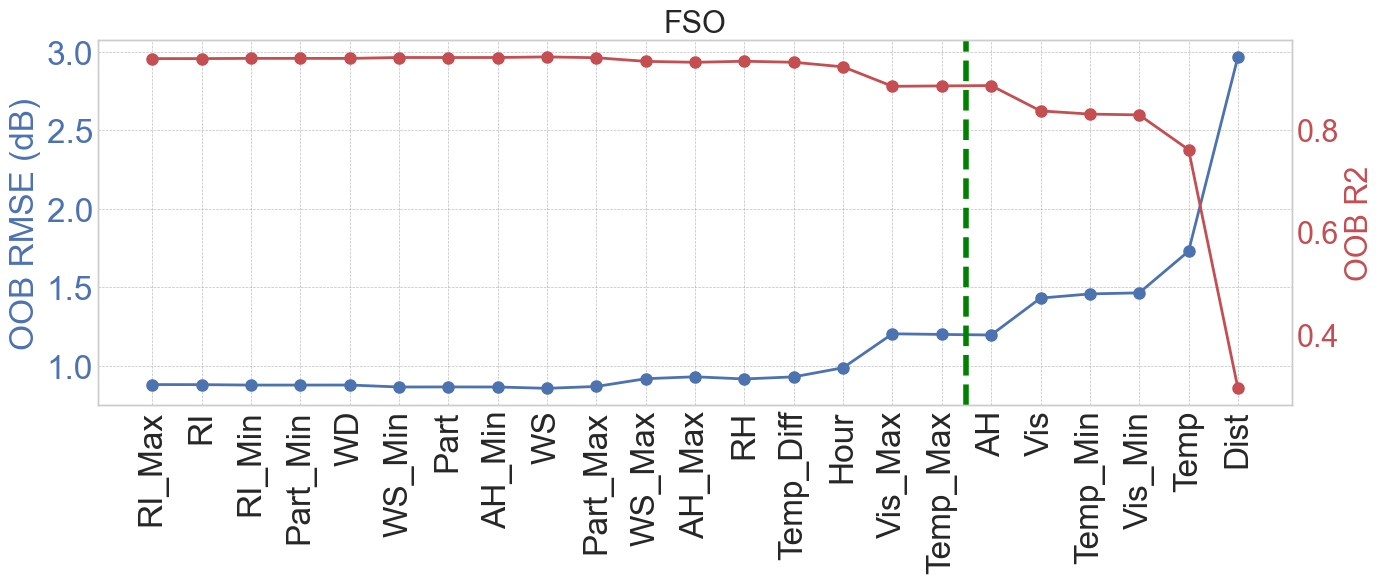

In [11]:
plot_green_line(FSO_Specific0_results["important_features"], 
                FSO_Specific0_results["rmse_list"], 
                FSO_Specific0_results["r2_list"],
                file_prefix="FSO_Specific0",
                point="Temp_Max")

In [12]:
FSO_Specific3_results = feature_selection_rf(X_data["X_Specific3"].drop(columns=["Freq"]), y_data_FSO["y_Specific3_FSO"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


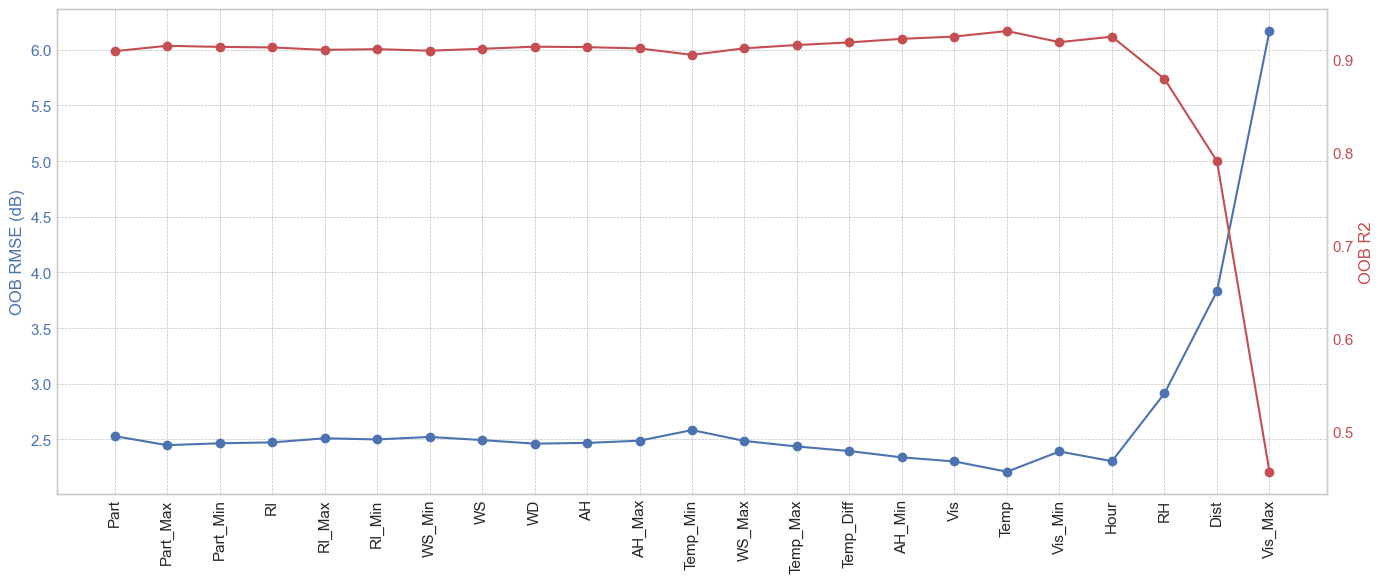

In [13]:
plot_rmse_r2_by_feature_importance(FSO_Specific3_results["important_features"], 
                                   FSO_Specific3_results["rmse_list"], 
                                   FSO_Specific3_results["r2_list"],
                                   file_prefix="FSO_Specific3")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


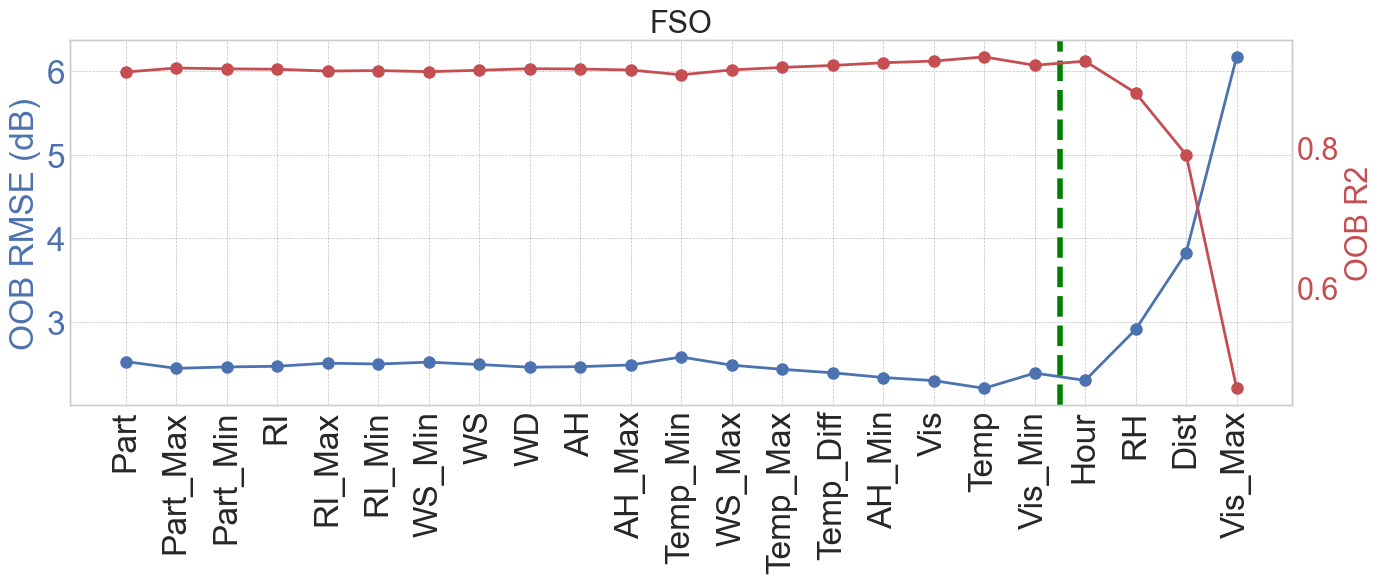

In [14]:
plot_green_line(FSO_Specific3_results["important_features"], 
                FSO_Specific3_results["rmse_list"], 
                FSO_Specific3_results["r2_list"],
                file_prefix="FSO_Specific3",
                point="Vis_Min")

In [15]:
FSO_Specific4_results = feature_selection_rf(X_data["X_Specific4"].drop(columns=["Freq"]), y_data_FSO["y_Specific4_FSO"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


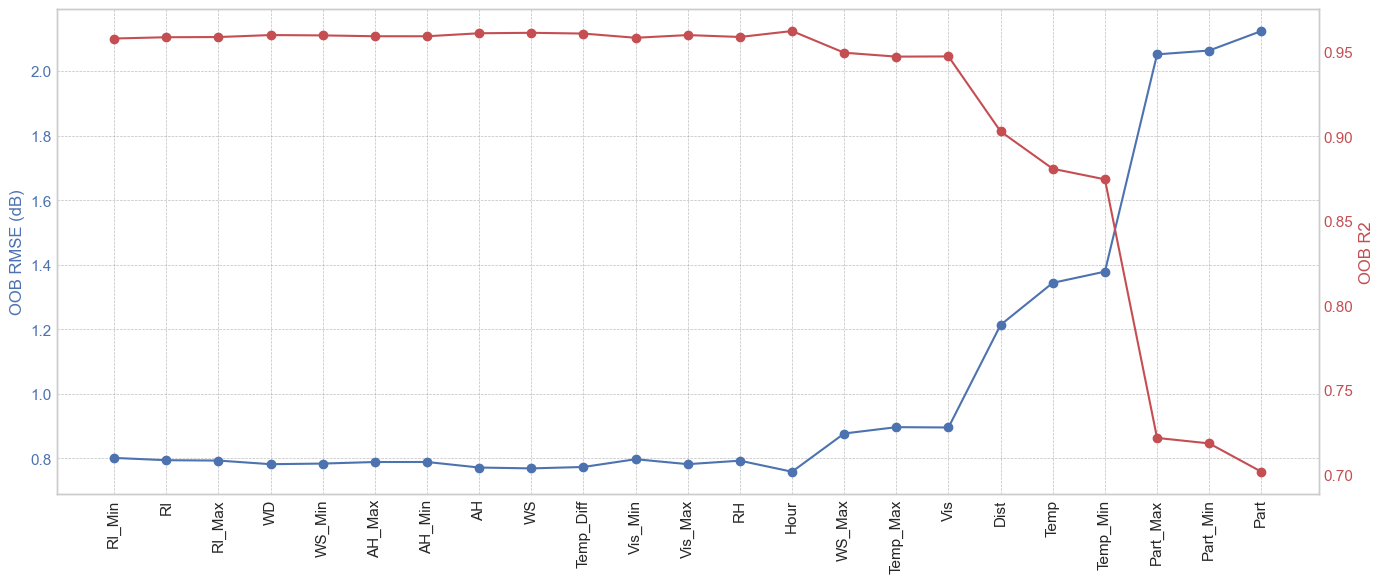

In [16]:
plot_rmse_r2_by_feature_importance(FSO_Specific4_results["important_features"], 
                                   FSO_Specific4_results["rmse_list"], 
                                   FSO_Specific4_results["r2_list"],
                                   file_prefix="FSO_Specific4",)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


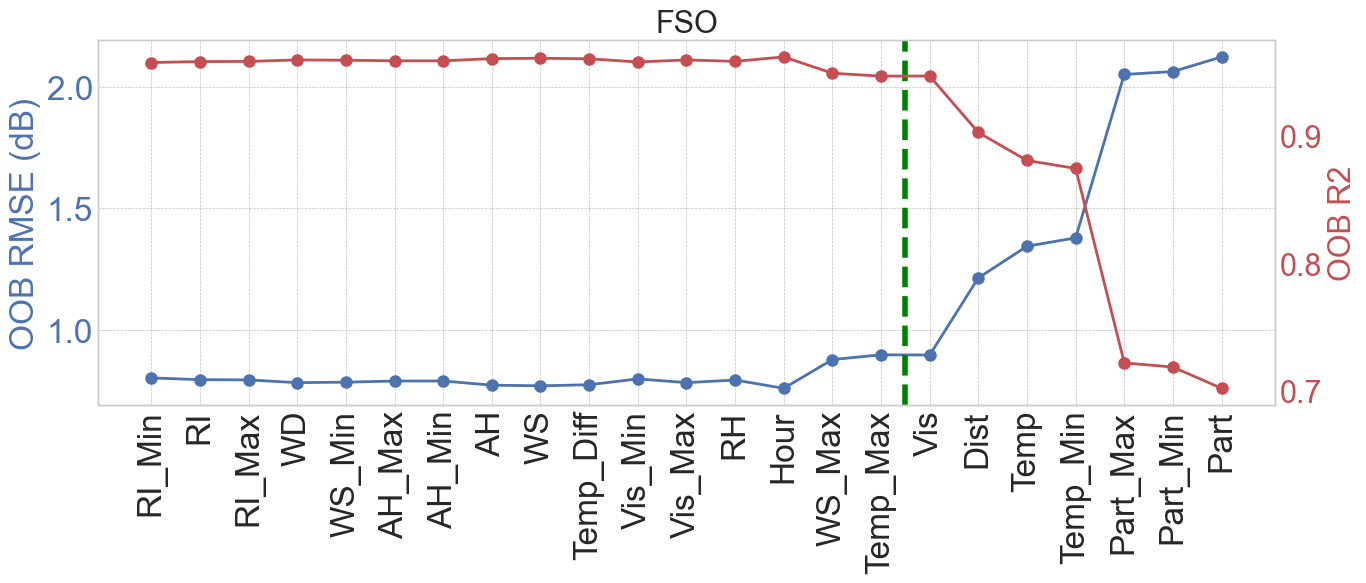

In [17]:
plot_green_line(FSO_Specific4_results["important_features"], 
                FSO_Specific4_results["rmse_list"], 
                FSO_Specific4_results["r2_list"],
                file_prefix="FSO_Specific4",
                point="Temp_Max")

In [18]:
FSO_Specific5_results = feature_selection_rf(X_data["X_Specific5"].drop(columns=["Freq"]), y_data_FSO["y_Specific5_FSO"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


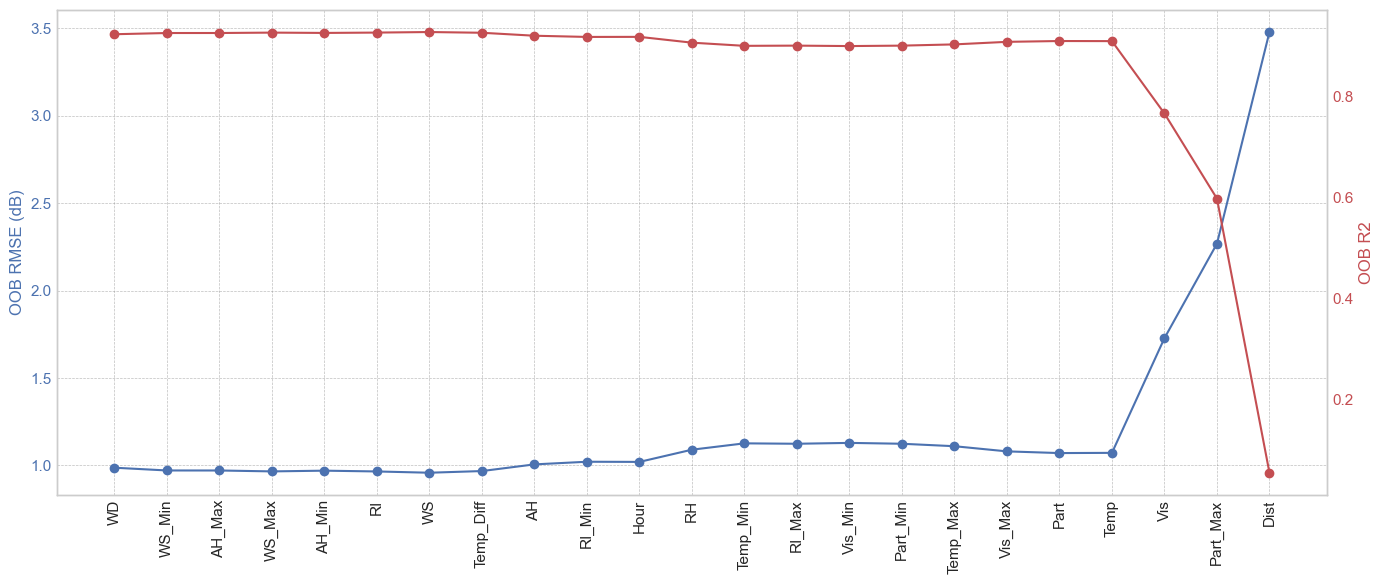

In [19]:
plot_rmse_r2_by_feature_importance(FSO_Specific5_results["important_features"], 
                                   FSO_Specific5_results["rmse_list"], 
                                   FSO_Specific5_results["r2_list"],
                                   file_prefix="FSO_Specific5")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


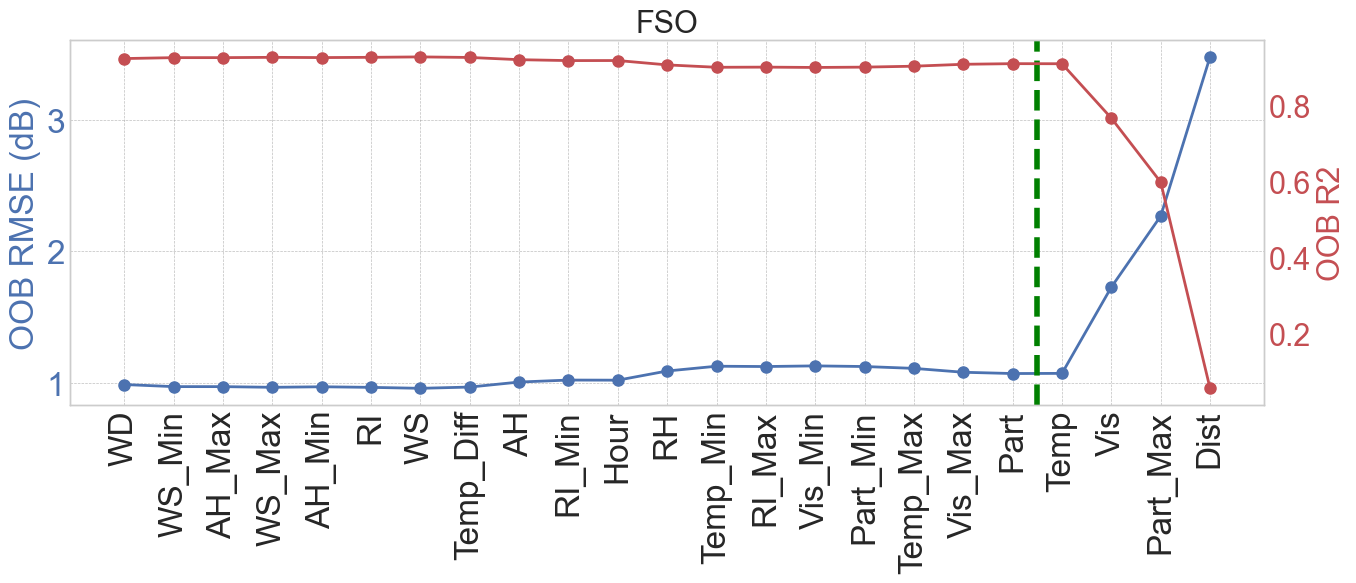

In [20]:
plot_green_line(FSO_Specific5_results["important_features"], 
                FSO_Specific5_results["rmse_list"], 
                FSO_Specific5_results["r2_list"],
                file_prefix="FSO_Specific5",
                point="Part")

In [21]:
FSO_Specific6_results = feature_selection_rf(X_data["X_Specific6"].drop(columns=["Freq"]), y_data_FSO["y_Specific6_FSO"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


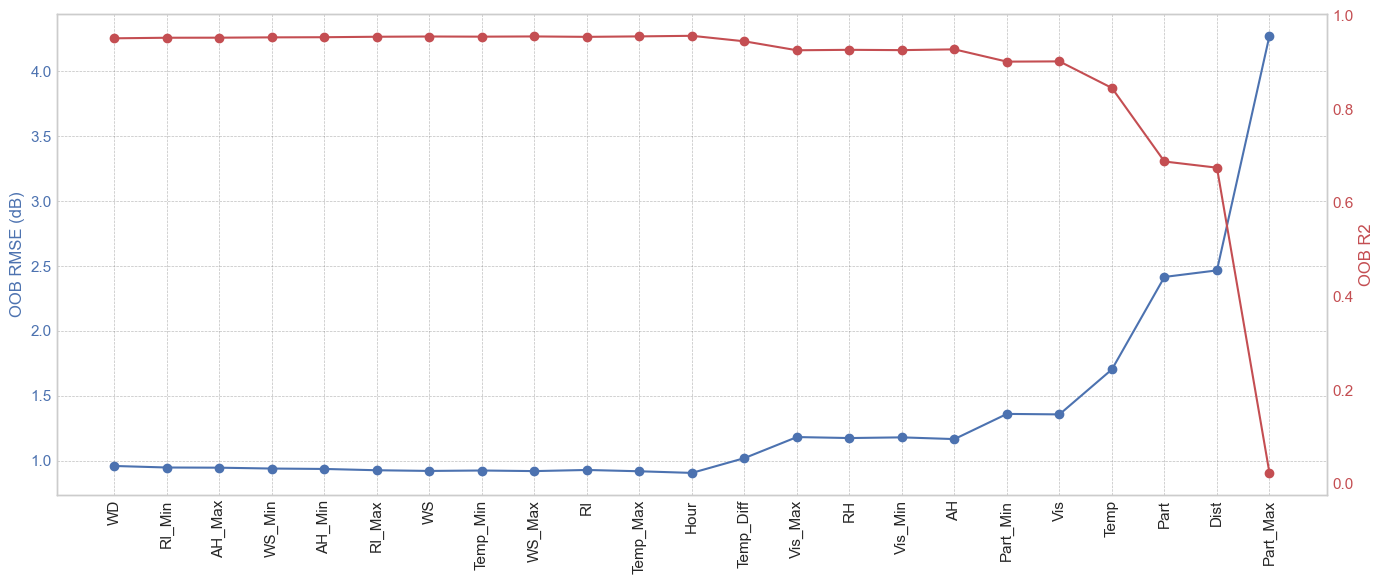

In [22]:
plot_rmse_r2_by_feature_importance(FSO_Specific6_results["important_features"], 
                                   FSO_Specific6_results["rmse_list"], 
                                   FSO_Specific6_results["r2_list"],
                                   file_prefix="FSO_Specific6")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


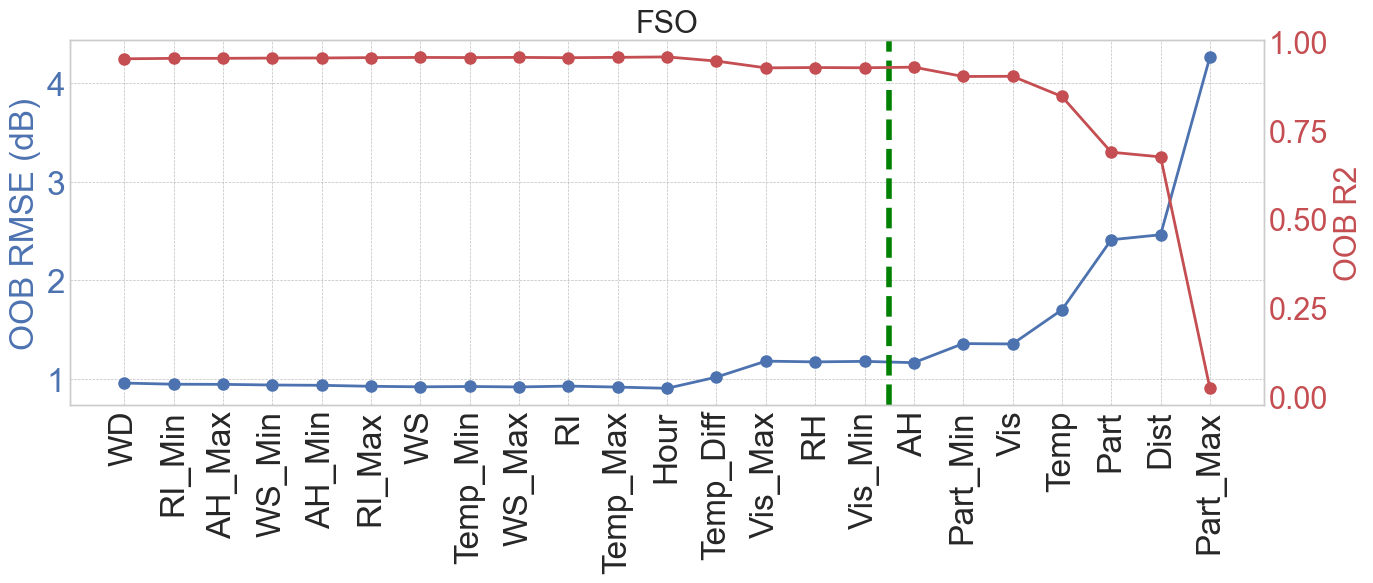

In [23]:
plot_green_line(FSO_Specific6_results["important_features"], 
                FSO_Specific6_results["rmse_list"], 
                FSO_Specific6_results["r2_list"],
                file_prefix="FSO_Specific6",
                point="Vis_Min")

In [24]:
FSO_Specific7_results = feature_selection_rf(X_data["X_Specific7"].drop(columns=["Freq"]), y_data_FSO["y_Specific7_FSO"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


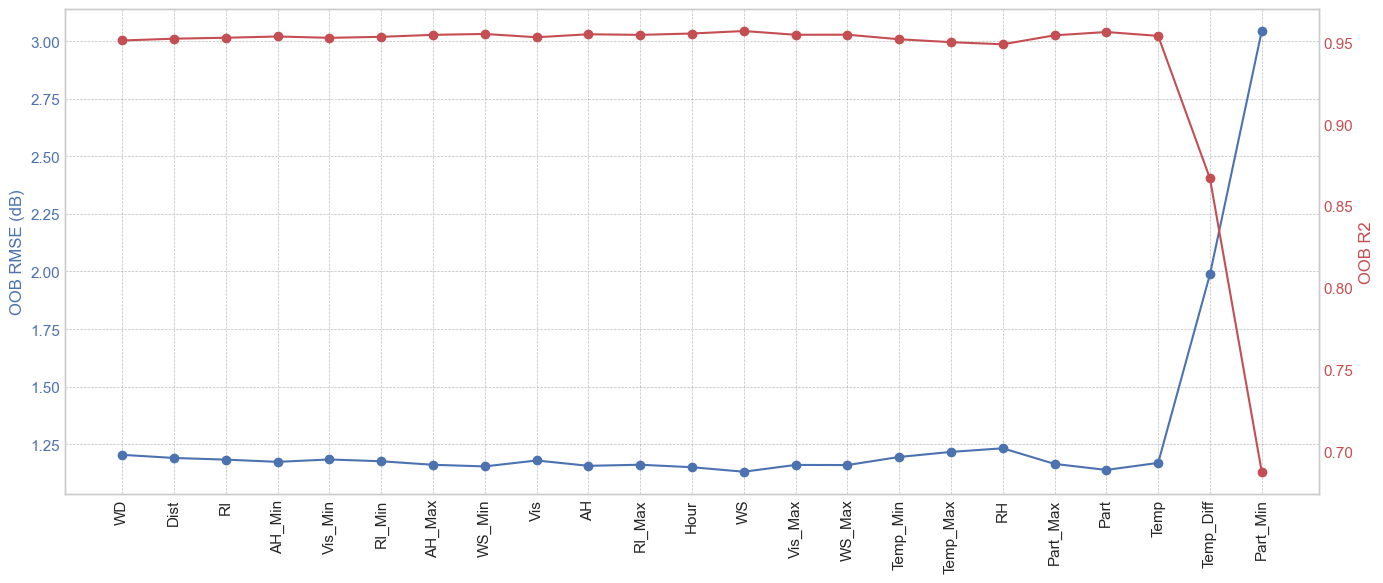

In [25]:
plot_rmse_r2_by_feature_importance(FSO_Specific7_results["important_features"], 
                                   FSO_Specific7_results["rmse_list"], 
                                   FSO_Specific7_results["r2_list"],
                                   file_prefix="FSO_Specific7")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


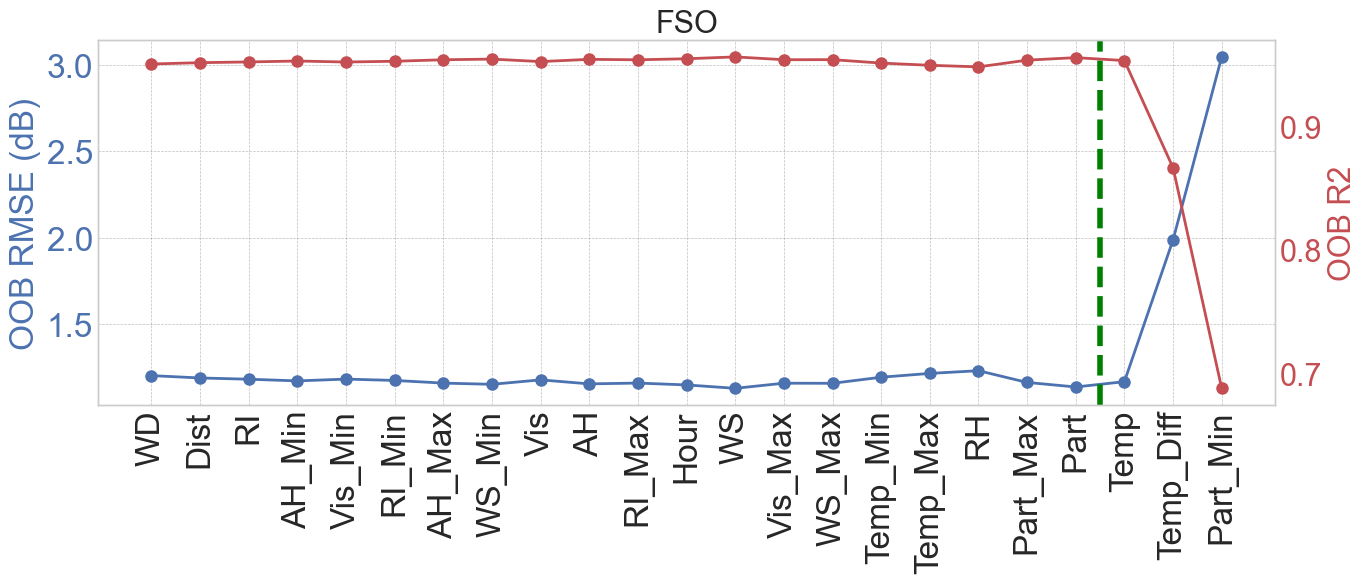

In [26]:
plot_green_line(FSO_Specific7_results["important_features"], 
                FSO_Specific7_results["rmse_list"], 
                FSO_Specific7_results["r2_list"],
                file_prefix="FSO_Specific7",
                point="Part")

In [27]:
FSO_Specific8_results = feature_selection_rf(X_data["X_Specific8"].drop(columns=["Freq"]), y_data_FSO["y_Specific8_FSO"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


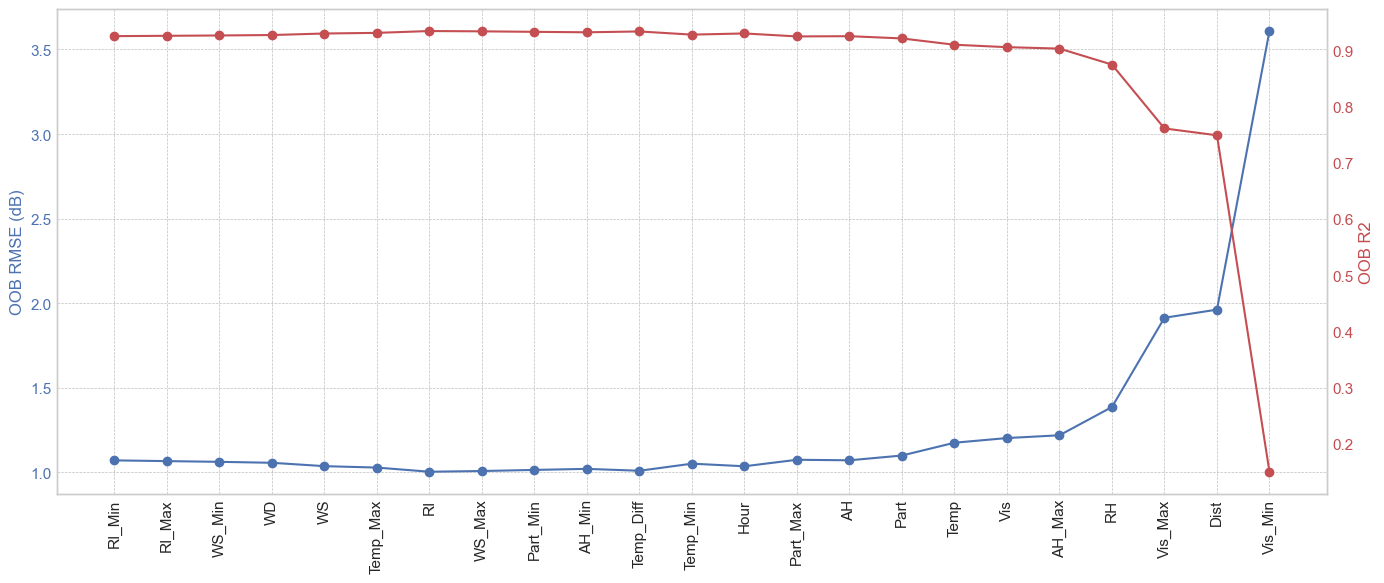

In [28]:
plot_rmse_r2_by_feature_importance(FSO_Specific8_results["important_features"], 
                                   FSO_Specific8_results["rmse_list"], 
                                   FSO_Specific8_results["r2_list"],
                                   file_prefix="FSO_Specific8")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


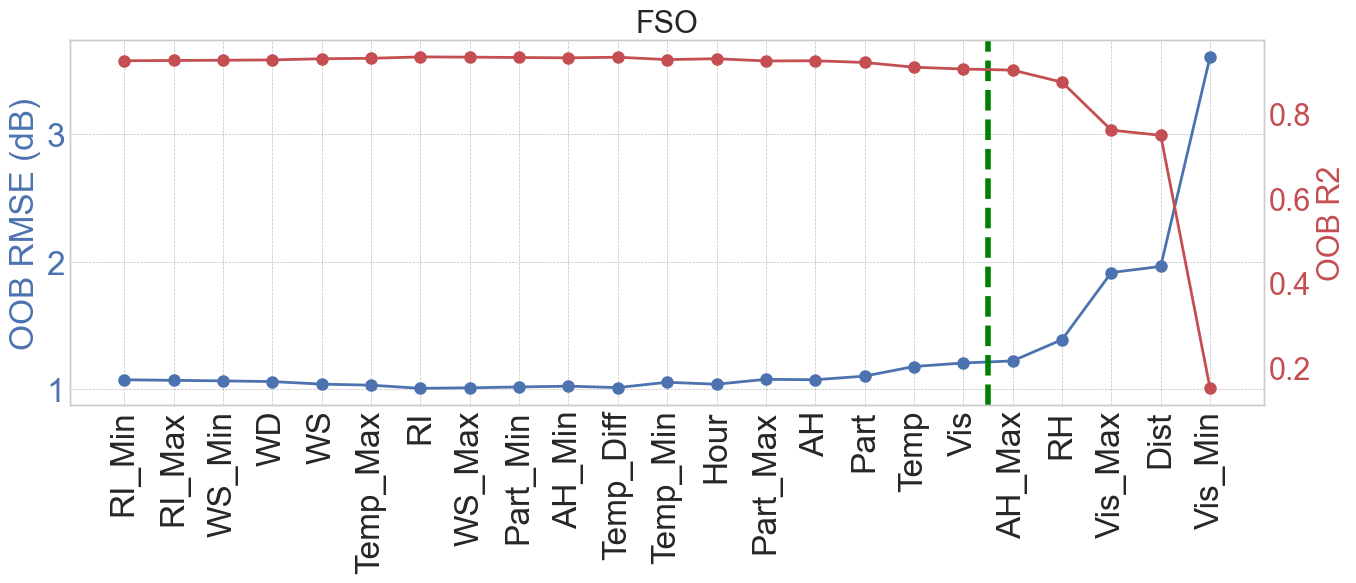

In [29]:
plot_green_line(FSO_Specific8_results["important_features"], 
                FSO_Specific8_results["rmse_list"], 
                FSO_Specific8_results["r2_list"],
                file_prefix="FSO_Specific8",
                point="Vis")

**(3) Feature Selection for Generic Model on RF Attenuation**

In [30]:
RF_Generic_results = feature_selection_rf(X_data["X_Generic"], y_data_RF["y_Generic_RF"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


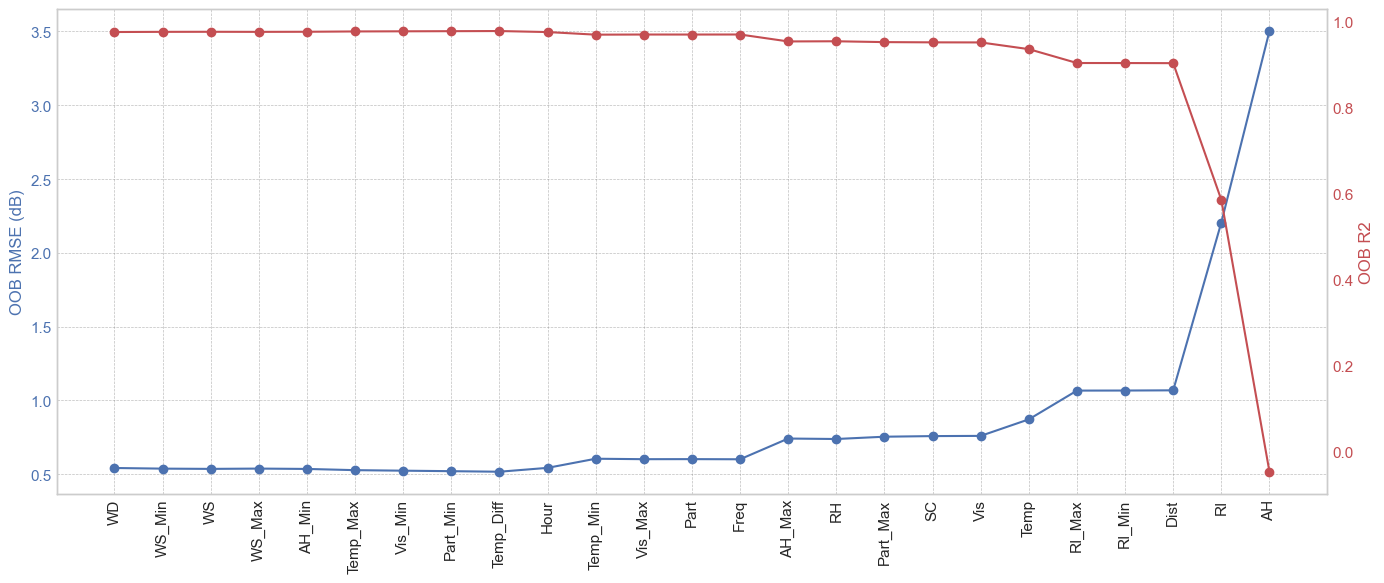

In [31]:
plot_rmse_r2_by_feature_importance(RF_Generic_results["important_features"], 
                                   RF_Generic_results["rmse_list"], 
                                   RF_Generic_results["r2_list"],
                                   file_prefix="RF_Generic")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


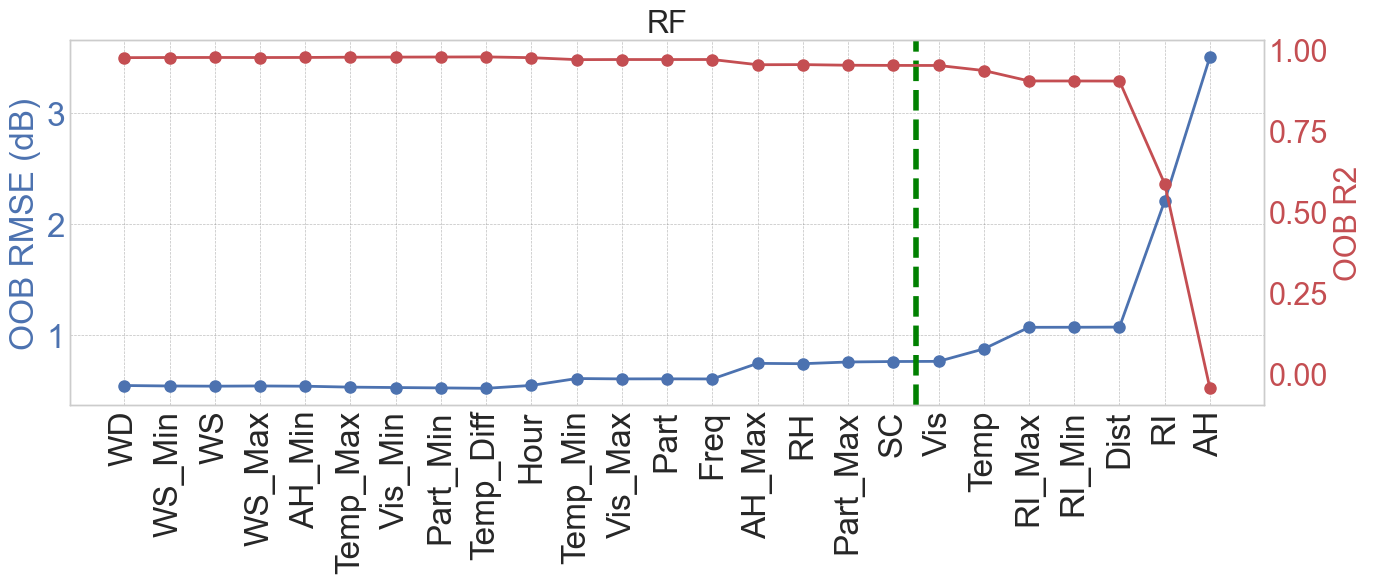

In [32]:
plot_green_line(RF_Generic_results["important_features"], 
                RF_Generic_results["rmse_list"], 
                RF_Generic_results["r2_list"],
                file_prefix="RF_Generic",
                point="SC")

**(4) Feature Selection for Specific Model on RF Attenuation**

In [33]:
RF_Specific0_results = feature_selection_rf(X_data["X_Specific0"], y_data_RF["y_Specific0_RF"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


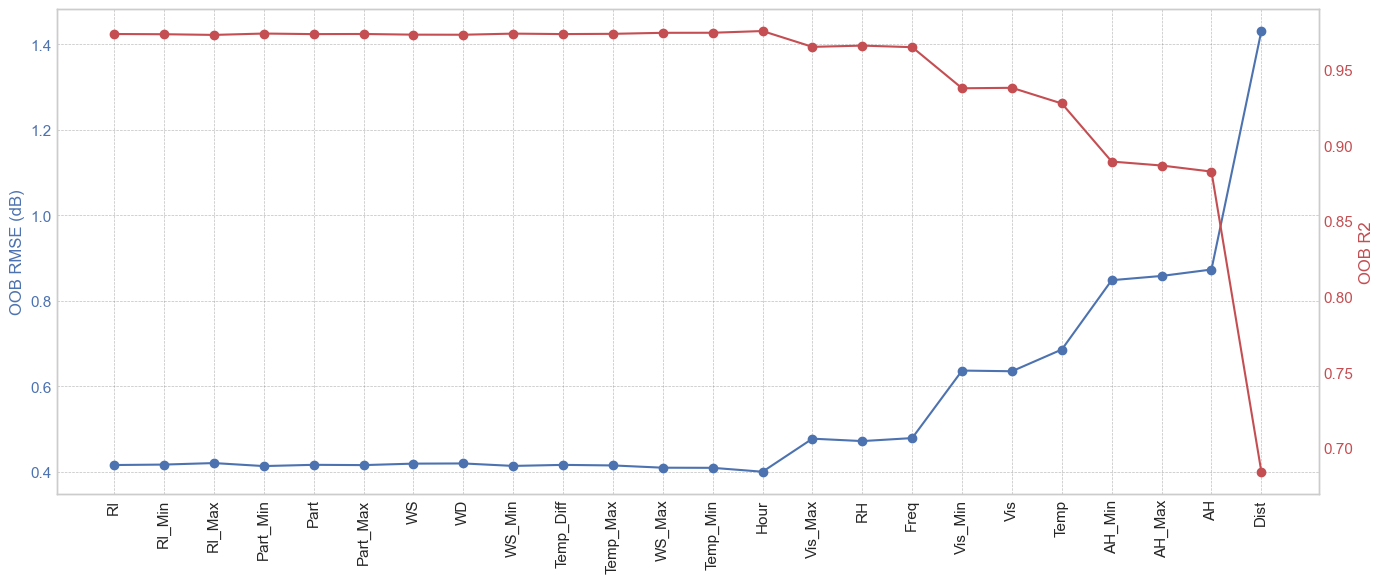

In [34]:
plot_rmse_r2_by_feature_importance(RF_Specific0_results["important_features"], 
                                   RF_Specific0_results["rmse_list"], 
                                   RF_Specific0_results["r2_list"],
                                   file_prefix="RF_Specific0")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


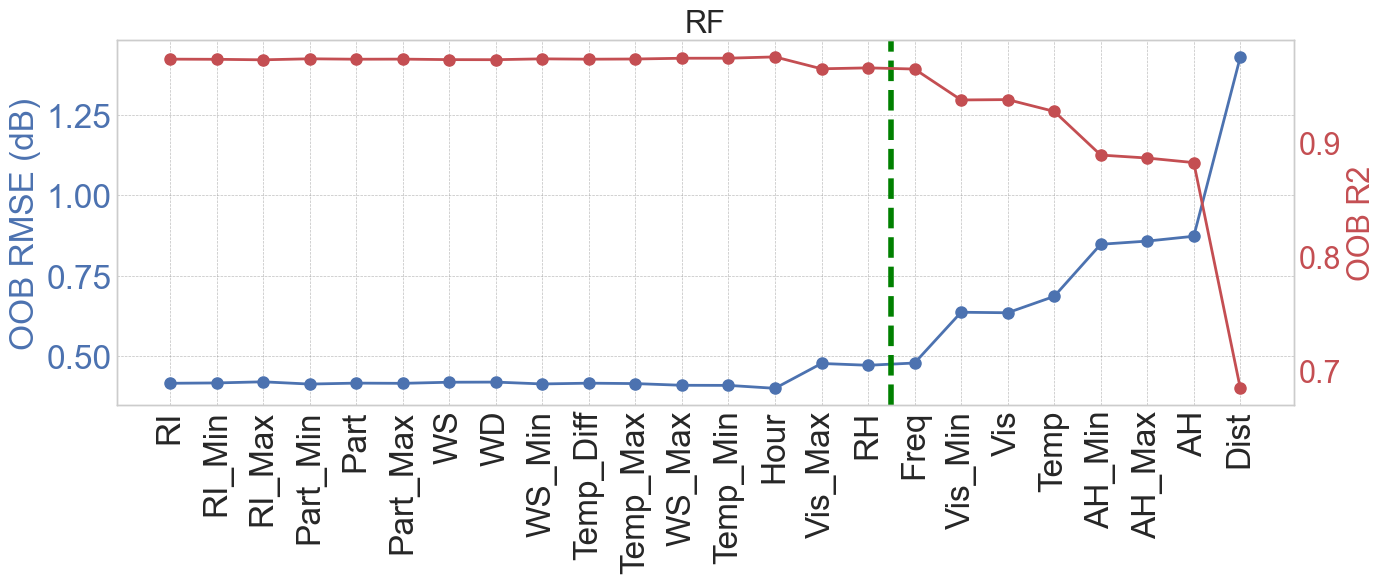

In [35]:
plot_green_line(RF_Specific0_results["important_features"], 
                RF_Specific0_results["rmse_list"], 
                RF_Specific0_results["r2_list"],
                file_prefix="RF_Specific0",
                point="RH")

In [36]:
RF_Specific3_results = feature_selection_rf(X_data["X_Specific3"], y_data_RF["y_Specific3_RF"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


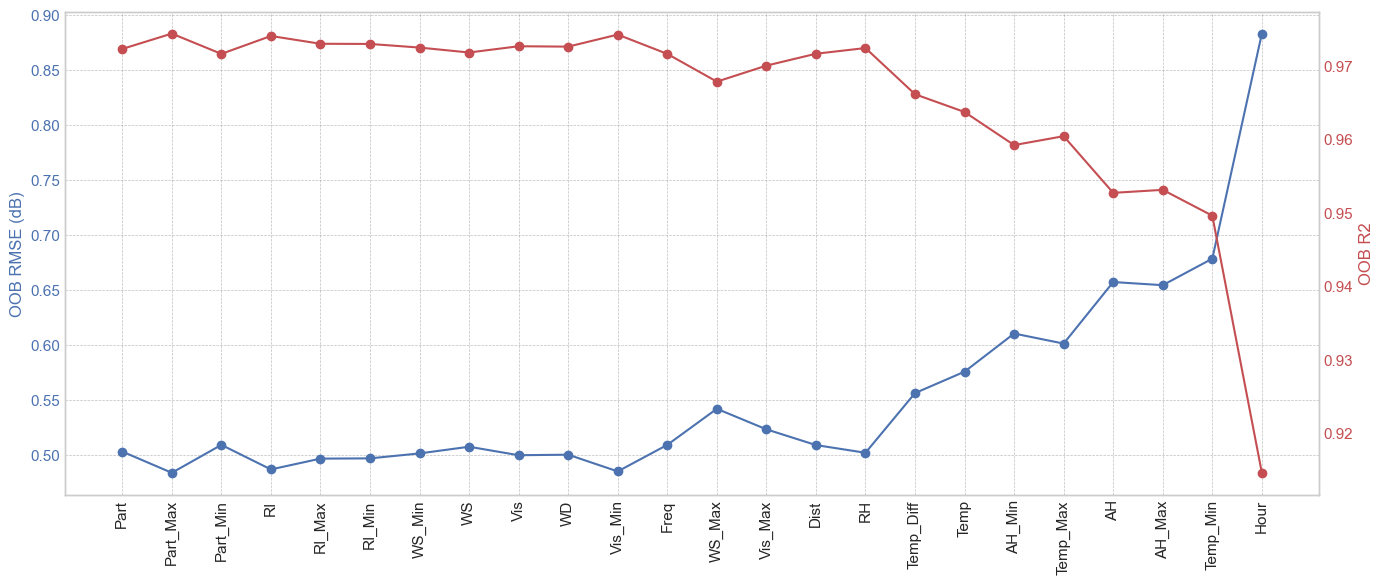

In [37]:
plot_rmse_r2_by_feature_importance(RF_Specific3_results["important_features"], 
                                   RF_Specific3_results["rmse_list"], 
                                   RF_Specific3_results["r2_list"],
                                   file_prefix="RF_Specific3")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


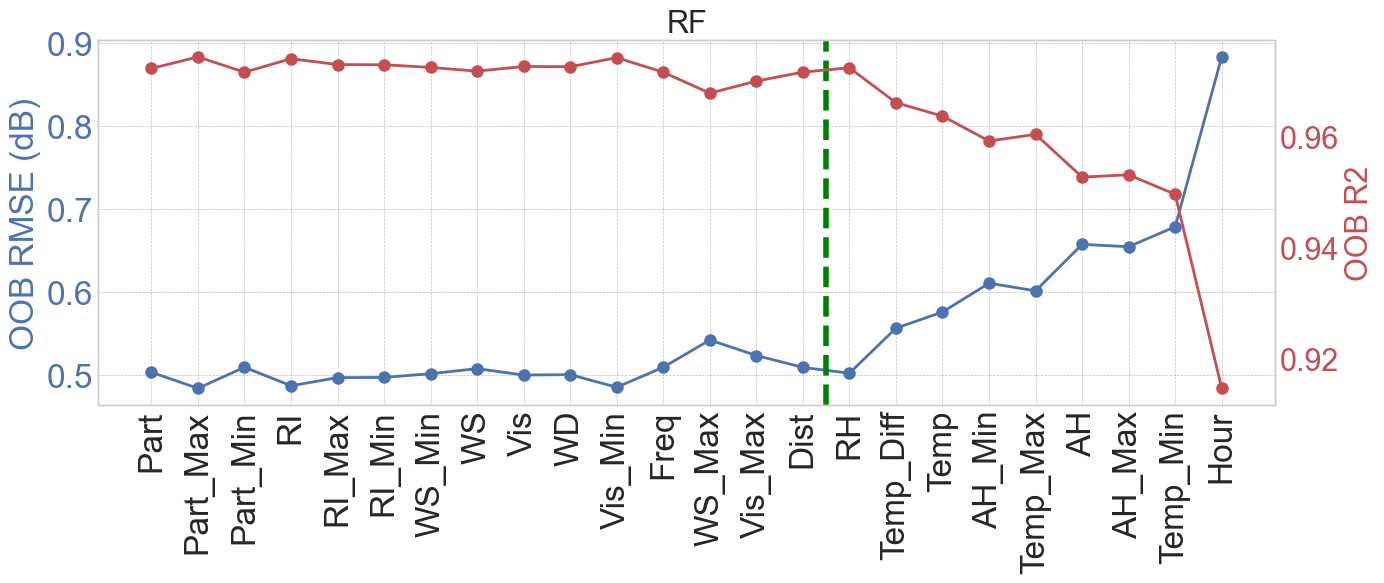

In [38]:
plot_green_line(RF_Specific3_results["important_features"], 
                RF_Specific3_results["rmse_list"], 
                RF_Specific3_results["r2_list"],
                file_prefix="RF_Specific3",
                point="Dist")

In [39]:
RF_Specific4_results = feature_selection_rf(X_data["X_Specific4"], y_data_RF["y_Specific4_RF"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


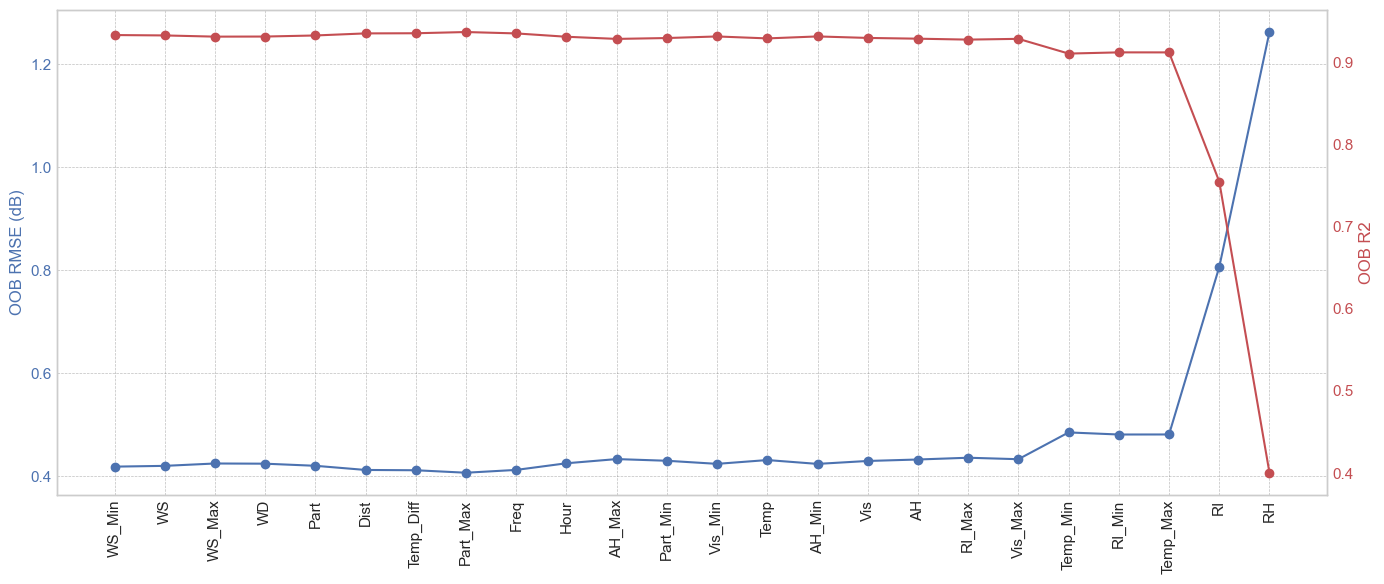

In [40]:
plot_rmse_r2_by_feature_importance(RF_Specific4_results["important_features"], 
                                   RF_Specific4_results["rmse_list"], 
                                   RF_Specific4_results["r2_list"],
                                   file_prefix="RF_Specific4")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


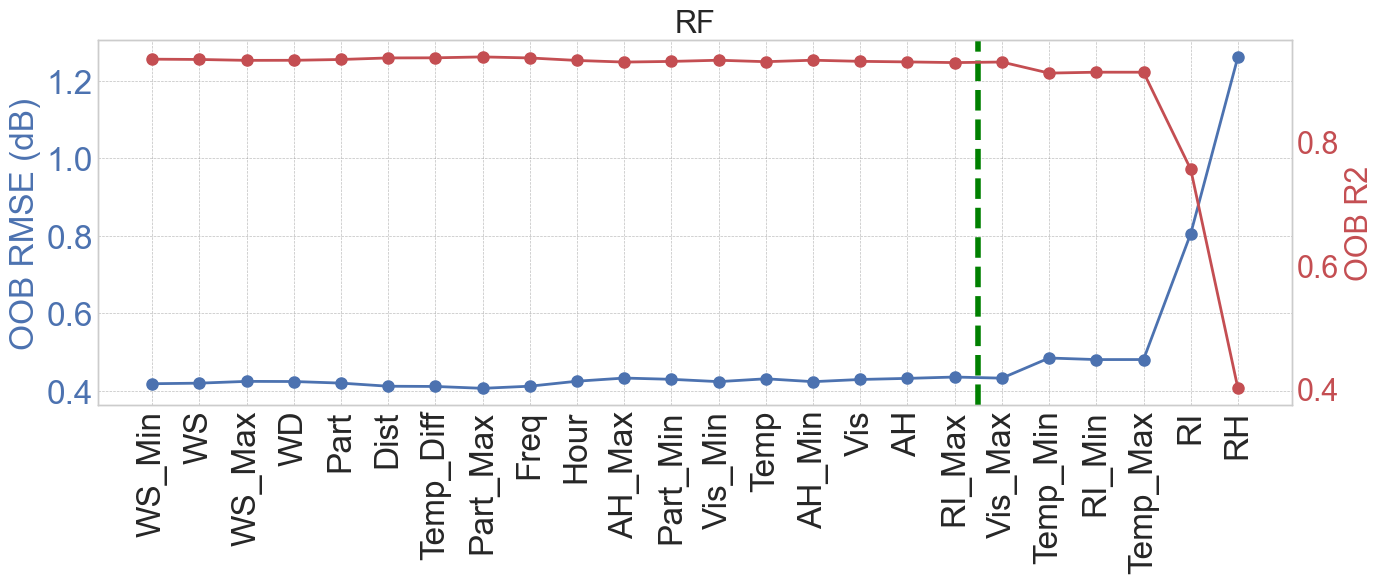

In [41]:
plot_green_line(RF_Specific4_results["important_features"], 
                RF_Specific4_results["rmse_list"], 
                RF_Specific4_results["r2_list"],
                file_prefix="RF_Specific4",
                point="RI_Max")

In [42]:
RF_Specific5_results = feature_selection_rf(X_data["X_Specific5"], y_data_RF["y_Specific5_RF"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


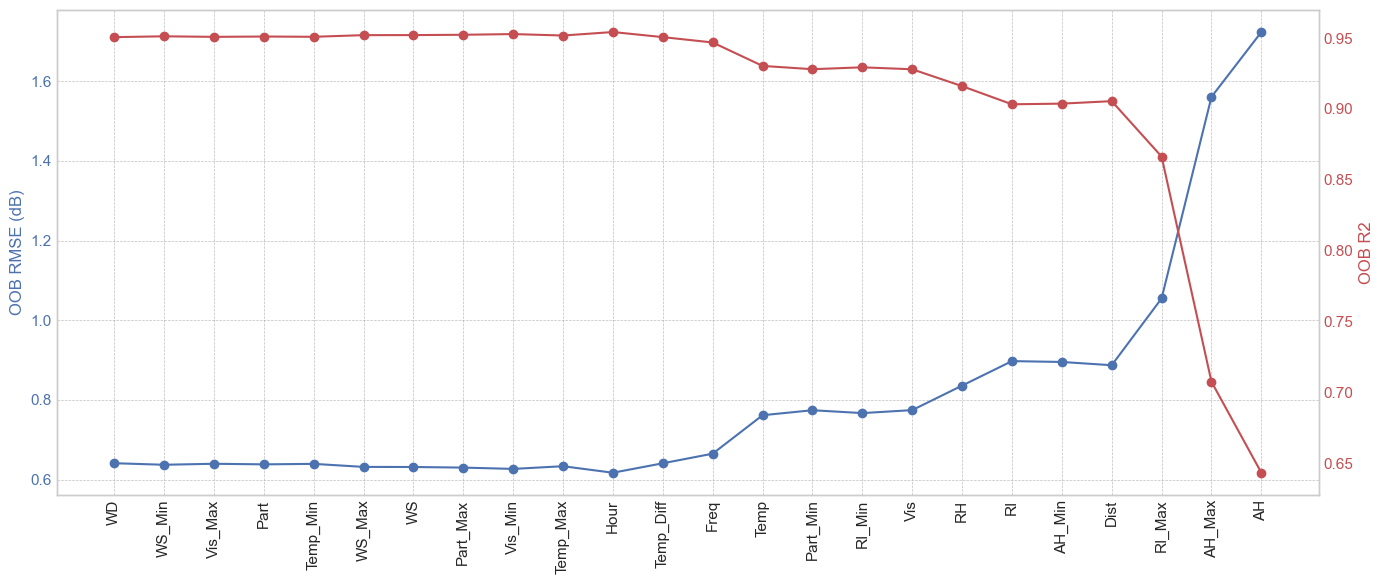

In [43]:
plot_rmse_r2_by_feature_importance(RF_Specific5_results["important_features"], 
                                   RF_Specific5_results["rmse_list"], 
                                   RF_Specific5_results["r2_list"],
                                   file_prefix="RF_Specific5")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


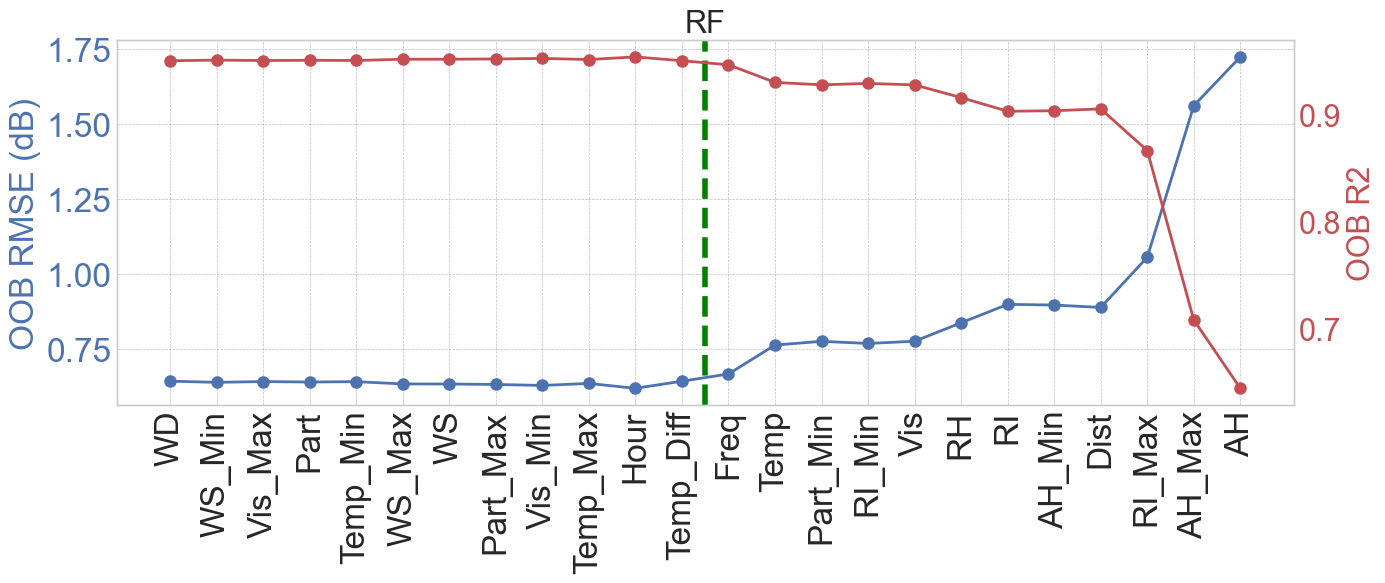

In [44]:
plot_green_line(RF_Specific5_results["important_features"], 
                RF_Specific5_results["rmse_list"], 
                RF_Specific5_results["r2_list"],
                file_prefix="RF_Specific5",
                point="Temp_Diff")

In [45]:
RF_Specific6_results = feature_selection_rf(X_data["X_Specific6"], y_data_RF["y_Specific6_RF"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


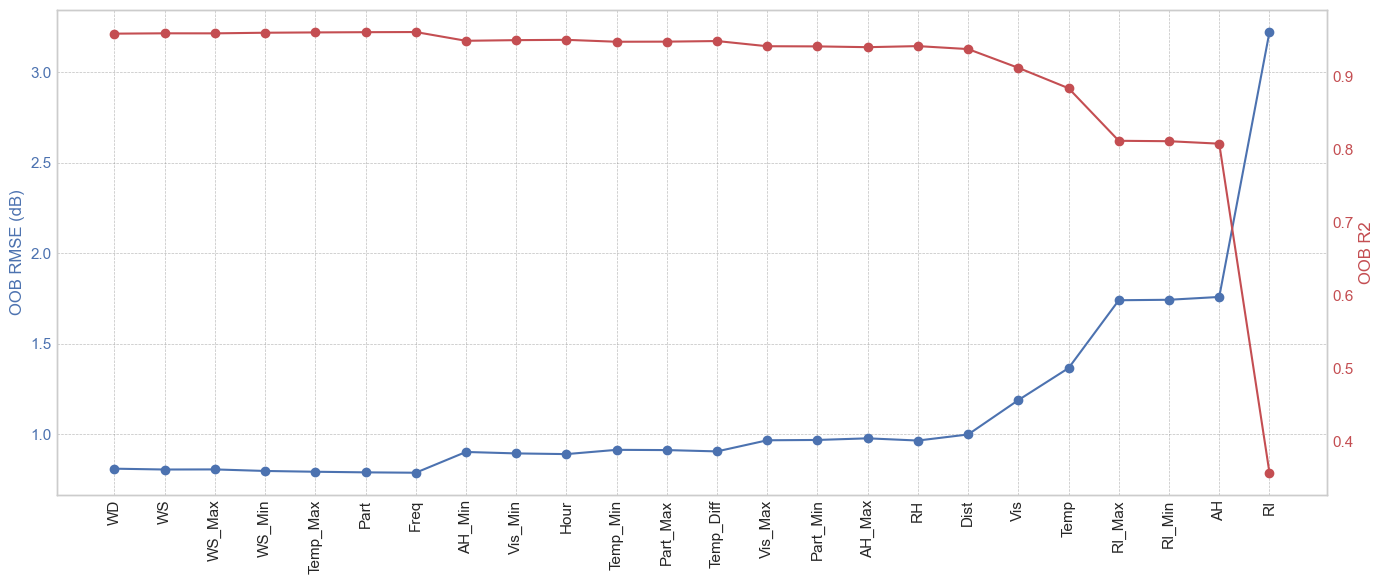

In [46]:
plot_rmse_r2_by_feature_importance(RF_Specific6_results["important_features"], 
                                   RF_Specific6_results["rmse_list"], 
                                   RF_Specific6_results["r2_list"],
                                   file_prefix="RF_Specific6")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


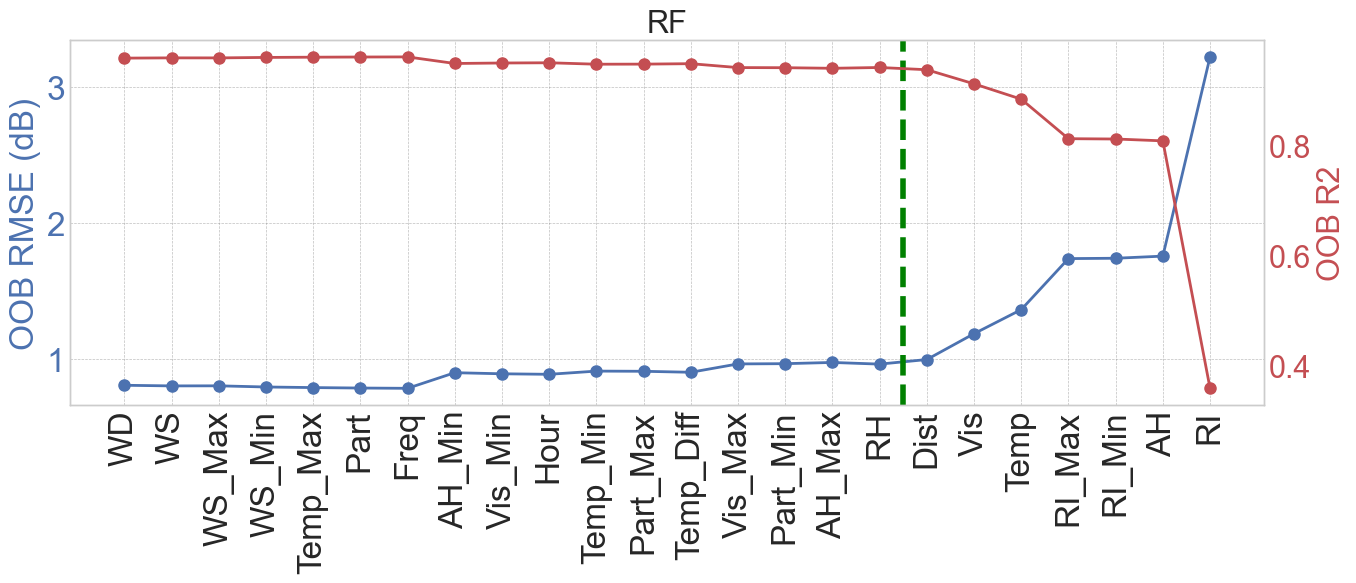

In [47]:
plot_green_line(RF_Specific6_results["important_features"], 
                RF_Specific6_results["rmse_list"], 
                RF_Specific6_results["r2_list"],
                file_prefix="RF_Specific6",
                point="RH")

In [48]:
RF_Specific7_results = feature_selection_rf(X_data["X_Specific7"], y_data_RF["y_Specific7_RF"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


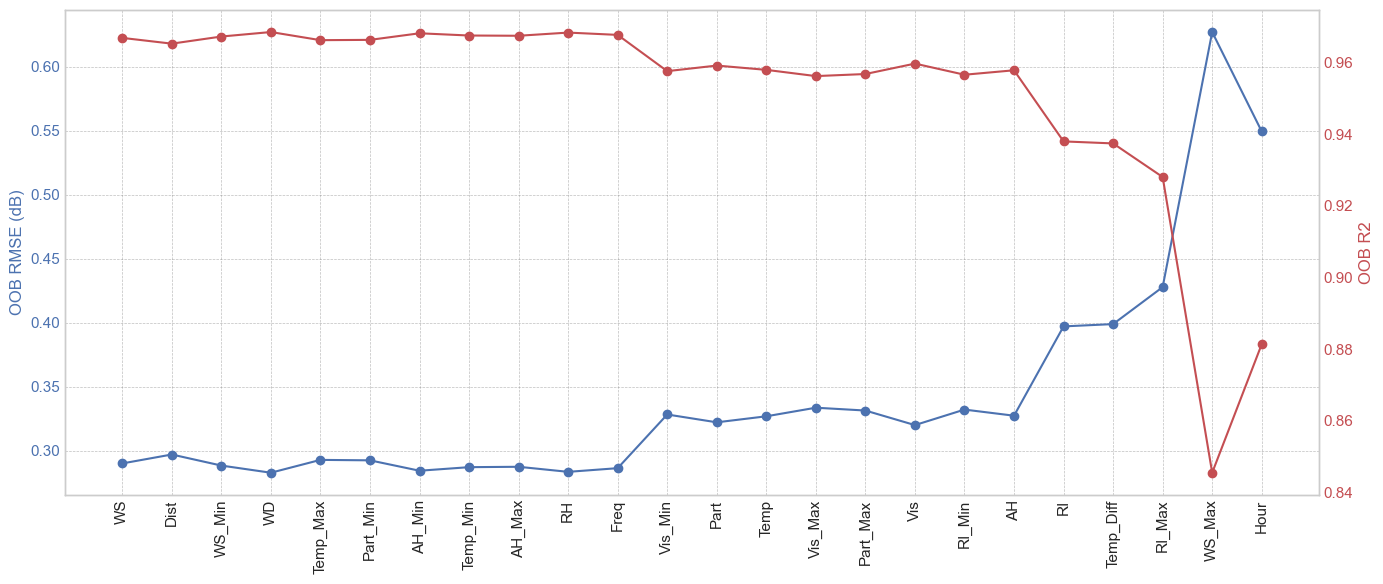

In [49]:
plot_rmse_r2_by_feature_importance(RF_Specific7_results["important_features"], 
                                   RF_Specific7_results["rmse_list"], 
                                   RF_Specific7_results["r2_list"],
                                   file_prefix="RF_Specific7")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


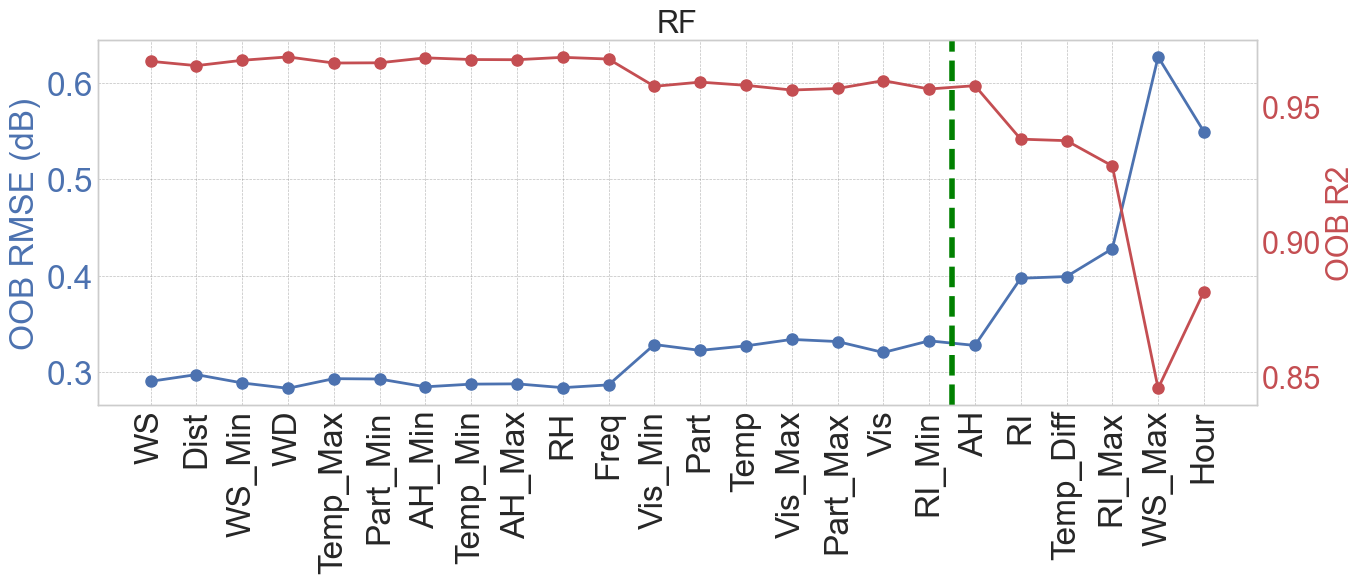

In [50]:
plot_green_line(RF_Specific7_results["important_features"], 
                RF_Specific7_results["rmse_list"], 
                RF_Specific7_results["r2_list"],
                file_prefix="RF_Specific7",
                point="RI_Min")

In [51]:
RF_Specific8_results = feature_selection_rf(X_data["X_Specific8"], y_data_RF["y_Specific8_RF"])

Feature Selection Complete


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


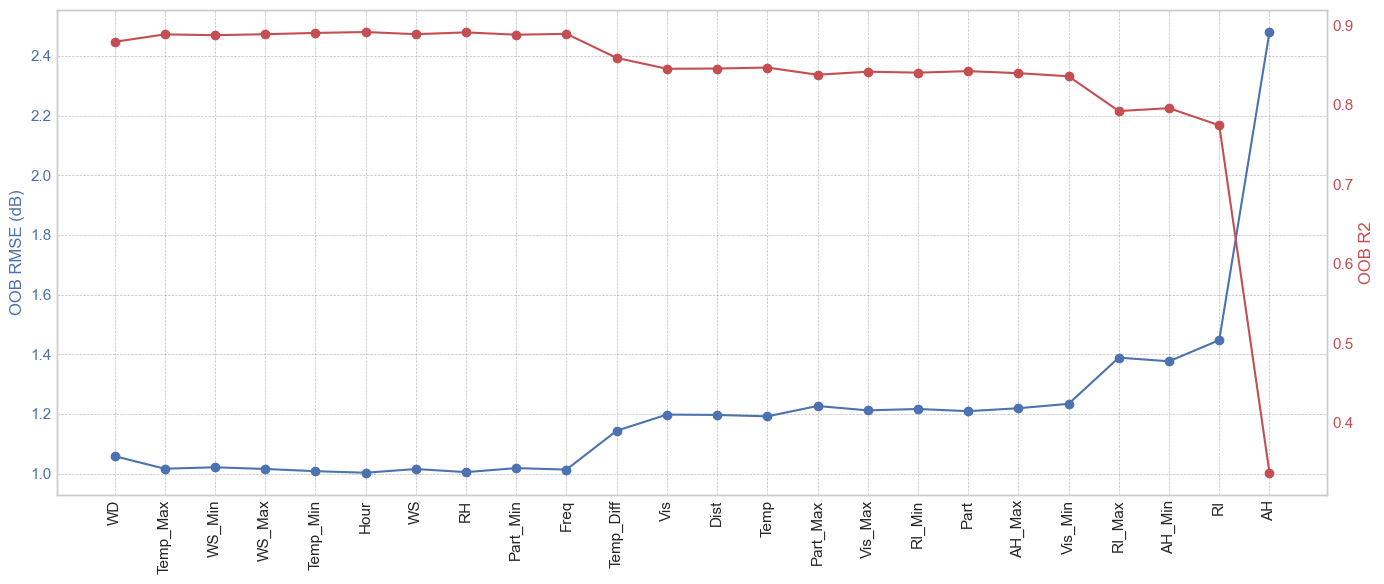

In [52]:
plot_rmse_r2_by_feature_importance(RF_Specific8_results["important_features"], 
                                   RF_Specific8_results["rmse_list"], 
                                   RF_Specific8_results["r2_list"],
                                   file_prefix="RF_Specific8")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


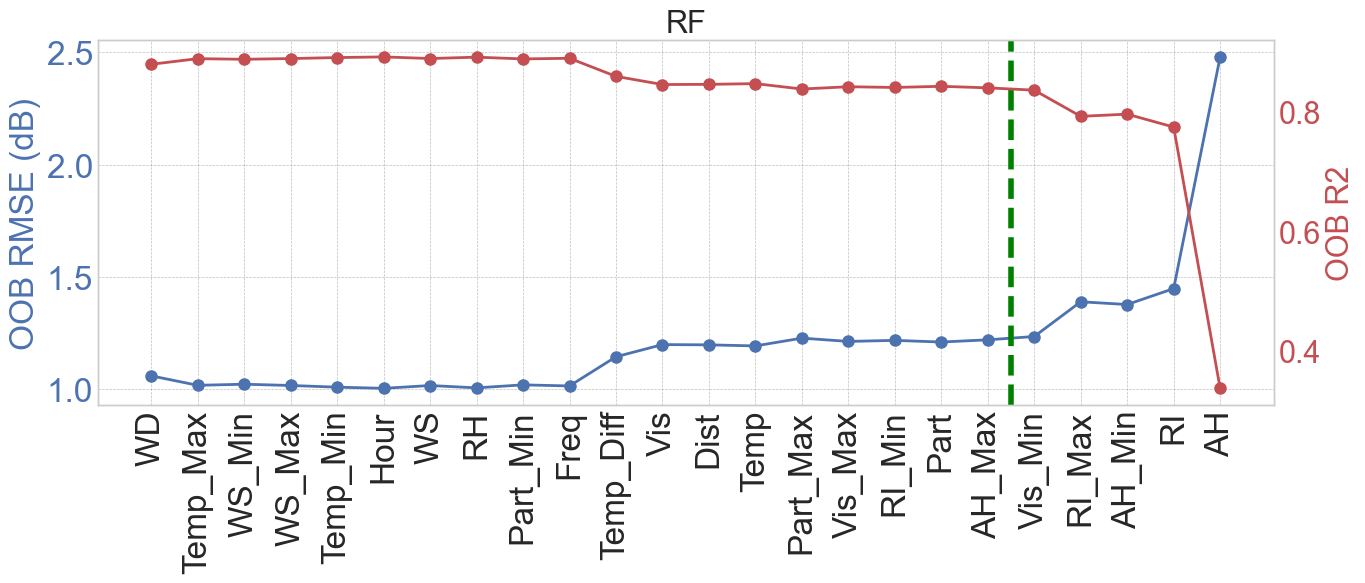

In [53]:
plot_green_line(RF_Specific8_results["important_features"], 
                RF_Specific8_results["rmse_list"], 
                RF_Specific8_results["r2_list"],
                file_prefix="RF_Specific8",
                point="AH_Max")

**(5) Identifying Important Features for Different Models Based on Image Results**

In [54]:
# Define important features for FSO and RF
important_features_FSO = {
    'Generic': ['AH', 'Vis_Min', 'Part_Min', 'Temp', 'Vis', 'Dist'],
    'Specific0': ['Hour', 'Vis_Max', 'Temp_Max', 'AH', 'Vis', 'Temp_Min', 'Vis_Min', 'Temp', 'Dist'],
    'Specific3': ['Hour', 'RH', 'Dist', 'Vis_Max'],
    'Specific4': ['Vis', 'Dist', 'Temp', 'Temp_Min', 'Part_Max', 'Part_Min', 'Part'],
    'Specific5': ['Temp', 'Vis', 'Part_Max', 'Dist'],
    'Specific6': ['AH', 'Part_Min', 'Vis', 'Temp', 'Part', 'Dist', 'Part_Max'],
    'Specific7': ['Temp', 'Temp_Diff', 'Part_Min'],
    'Specific8': ['AH_Max', 'RH', 'Vis_Max', 'Dist', 'Vis_Min']
}

important_features_RF = {
    'Generic': ['Vis', 'Temp', 'RI_Max', 'RI_Min', 'Dist', 'RI', 'AH'],
    'Specific0': ['Freq', 'Vis_Min', 'Vis', 'Temp', 'AH_Min', 'AH_Max', 'AH', 'Dist'],
    'Specific3': ['RH', 'Temp_Diff', 'Temp', 'AH_Min', 'Temp_Max', 'AH', 'AH_Max', 'Temp_Min', 'Hour'],
    'Specific4': ['Vis_Max', 'Temp_Min', 'RI_Min', 'Temp_Max', 'RI', 'RH'],
    'Specific5': ['Freq', 'Temp', 'Part_Min', 'RI_Min', 'Vis', 'RH', 'RI', 'AH_Min', 'Dist', 'RI_Max', 'AH_Max', 'AH'],
    'Specific6': ['Dist', 'Vis', 'Temp', 'RI_Max', 'RI_Min', 'AH', 'RI'],
    'Specific7': ['AH', 'RI', 'Temp_Diff', 'RI_Max', 'WS_Max', 'Hour'],
    'Specific8': ['Vis_Min', 'RI_Max', 'AH_Min', 'RI', 'AH']
}


**(6) Training Sets After Feature Selection**

In [55]:
# Create directories to save the files if they don't already exist
os.makedirs("Data/Splitting/Feature_Selection", exist_ok=True)

In [56]:
# Function to load, filter, and save datasets
def process_and_save_datasets(X_data, feature_dict, prefix, sets):
    for name, features in feature_dict.items():
        # Load dataset
        X = X_data[name]
        
        # Select only important features
        X_filtered = X[features]
        
        # Save to CSV
        X_filtered.to_csv(f'Data/Splitting/Feature_Selection/{sets}_{prefix}_{name}.csv', index=False)


In [57]:
# Load datasets
X_train_data = {
    'Generic': pd.read_csv("Data/Splitting/Generic/X_train.csv"),
    'Specific0': pd.read_csv("Data/Splitting/Specific/train_X_SC_0.csv"),
    'Specific3': pd.read_csv("Data/Splitting/Specific/train_X_SC_3.csv"),
    'Specific4': pd.read_csv("Data/Splitting/Specific/train_X_SC_4.csv"),
    'Specific5': pd.read_csv("Data/Splitting/Specific/train_X_SC_5.csv"),
    'Specific6': pd.read_csv("Data/Splitting/Specific/train_X_SC_6.csv"),
    'Specific7': pd.read_csv("Data/Splitting/Specific/train_X_SC_7.csv"),
    'Specific8': pd.read_csv("Data/Splitting/Specific/train_X_SC_8.csv")
}

# Process and save datasets
process_and_save_datasets(X_train_data, important_features_FSO, "X_FSO","train")
process_and_save_datasets(X_train_data, important_features_RF, "X_RF","train")

print("New training datasets with important features for FSO and RF created successfully.")

New training datasets with important features for FSO and RF created successfully.


**(7) Validation Sets After Feature Selection**

In [58]:
# Create directories to save the files if they don't already exist
os.makedirs("Data/Splitting/Feature_Selection/Generic_Validation", exist_ok=True)

# Define important features for FSO and RF (Generic only)
generic_features_FSO = important_features_FSO['Generic']
generic_features_RF = important_features_RF['Generic']

# Define paths for the specific datasets
X_val_paths = {
    'Generic': "Data/Splitting/Generic/X_val.csv",
    'Specific0': "Data/Splitting/Specific/val_X_SC_0.csv",
    'Specific3': "Data/Splitting/Specific/val_X_SC_3.csv",
    'Specific4': "Data/Splitting/Specific/val_X_SC_4.csv",
    'Specific5': "Data/Splitting/Specific/val_X_SC_5.csv",
    'Specific6': "Data/Splitting/Specific/val_X_SC_6.csv",
    'Specific7': "Data/Splitting/Specific/val_X_SC_7.csv",
    'Specific8': "Data/Splitting/Specific/val_X_SC_8.csv",
    'Generic_Test': "Data/Splitting/Generic/X_test.csv",
}

# Loop over each dataset and create a new one with only Generic features
for name, path in X_val_paths.items():
    # Load the dataset
    X_val = pd.read_csv(path)
    
    # Select only the Generic important features for FSO and RF
    X_fso_generic = X_val[generic_features_FSO]
    X_rf_generic = X_val[generic_features_RF]
    
    # Save the new datasets
    X_fso_generic.to_csv(f"Data/Splitting/Feature_Selection/Generic_Validation/X_FSO_{name}.csv", index=False)
    X_rf_generic.to_csv(f"Data/Splitting/Feature_Selection/Generic_Validation/X_RF_{name}.csv", index=False)

print("New validation datasets with Generic important features for FSO and RF created successfully.")

New validation datasets with Generic important features for FSO and RF created successfully.


In [ ]:
# Load datasets
X_val_data = {
    'Generic': pd.read_csv("Data/Splitting/Generic/X_val.csv"),
    'Specific0': pd.read_csv("Data/Splitting/Specific/val_X_SC_0.csv"),
    'Specific3': pd.read_csv("Data/Splitting/Specific/val_X_SC_3.csv"),
    'Specific4': pd.read_csv("Data/Splitting/Specific/val_X_SC_4.csv"),
    'Specific5': pd.read_csv("Data/Splitting/Specific/val_X_SC_5.csv"),
    'Specific6': pd.read_csv("Data/Splitting/Specific/val_X_SC_6.csv"),
    'Specific7': pd.read_csv("Data/Splitting/Specific/val_X_SC_7.csv"),
    'Specific8': pd.read_csv("Data/Splitting/Specific/val_X_SC_8.csv")
}

# Process and save datasets
process_and_save_datasets(X_val_data, important_features_FSO, "X_FSO","val")
process_and_save_datasets(X_val_data, important_features_RF, "X_RF","val")

print("New validation datasets with Specific important features for FSO and RF created successfully.")